In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import print_function
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

#I can't get this to work
## Install Altair and activate its colab renderer.
#print("Installing Altair...")
#!pip install git+git://github.com/altair-viz/altair.git
#import altair as alt
#alt.data_transformers.enable('default', max_rows=None)
#alt.renderers.enable('notebook')
#print("Done installing Altair.")
#

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def build_rating_sparse_tensor(user_artists_df):

    indices = user_artists_df[['userID', 'artistID']].values
    values = user_artists_df['rating'].values

    return tf.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=[len(user_artists.userID.unique()), artists.shape[0]])

In [3]:
user_artists = pd.read_csv('../data/user_artists_ratings.csv')
user_friends = pd.read_csv('../data/user_friends.csv')
user_taggedartists = pd.read_csv('../data/user_taggedartists.csv')
artists = pd.read_csv('../data/artists.csv')
tags = pd.read_table('../data/tags.dat', sep='\t', encoding='latin-1')
artists_tags = pd.read_csv('../data/artists_tags.csv')

In [4]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, music_embeddings):

    predictions = tf.reduce_sum(
        tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
        tf.gather(music_embeddings, sparse_ratings.indices[:, 1]),
        axis=1)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

In [5]:
class CFModel(object):
    """Simple class that represents a collaborative filtering model"""
    def __init__(self, embedding_vars, loss, metrics=None):
        """Initializes a CFModel.
        Args:
          embedding_vars: A dictionary of tf.Variables.
          loss: A float Tensor. The loss to optimize.
          metrics: optional list of dictionaries of Tensors. The metrics in each
            dictionary will be plotted in a separate figure during training.
        """
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None

    @property
    def embeddings(self):
        """The embeddings dictionary."""
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
              optimizer=tf.train.GradientDescentOptimizer):
        """Trains the model.
        Args:
          iterations: number of iterations to run.
          learning_rate: optimizer learning rate.
          plot_results: whether to plot the results at the end of training.
          optimizer: the optimizer to use. Default to GradientDescentOptimizer.
        Returns:
          The metrics dictionary evaluated at the last iteration.
        """
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
                tf.variables_initializer(opt.variables()),
                tf.local_variables_initializer())
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            # Train and append results.
            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(
                        ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                          end='')
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)

            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            if plot_results:
                # Plot the metrics.
                num_subplots = len(metrics)+1
                fig = plt.figure()
                fig.set_size_inches(num_subplots*10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i+1)
                    for k, v in metric_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.legend()
            return results

In [6]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
    
    # Split the ratings DataFrame into train and test
    train_ratings, test_ratings = split_dataframe(ratings)
    # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random_normal(
        [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal(
        [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {
        'train_error': train_loss,
        'test_error': test_loss
    }
    embeddings = {
        "userID": U,
        "artistID": V
    }
    return CFModel(embeddings, train_loss, [metrics])

In [7]:
def split_dataframe(df, holdout_fraction=0.1):
  
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [8]:
## Might not be necessary 

#user_artists = user_artists[['userID', 'artistID', 'rating']]

#user_artists['userID'] = user_artists['userID'].astype(str)
#user_artists['artistID'] = user_artists['artistID'].astype(str)
#user_artists['rating'] = user_artists['rating'].astype(float)

#user_artists = user_artists.sample(frac=1).reset_index(drop=True)

 iteration 1000: train_error=0.198244, test_error=4.623462

[{'train_error': 0.19824356, 'test_error': 4.6234617}]

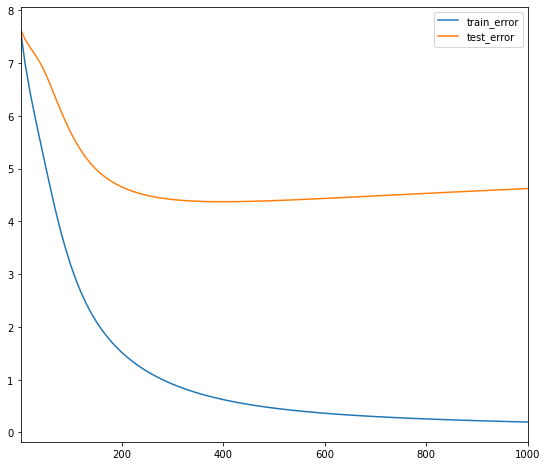

In [9]:
model = build_model(user_artists, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)